<a href="https://colab.research.google.com/github/Shounak-Ghosh/AI_Projects/blob/master/22shounakg_NN_ConscientiousCars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog Detection for Self Driving Cars


Self driving cars are very good at regcognizing and avoiding humans, and we aim to make these vehicles more conscientious of their surroundings by allowing them to differentaite dogs from roads, so they are also safe from potential collisions. Thus, we will build an image classifier that can distinguish between a dog and the road.


In [1]:
#@title Run this to load some packages and data! { display-mode: "form" }
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from collections import Counter
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def categorical_to_numpy(labels_in):
  labels = []
  for label in labels_in:
    if label == 'dog':
      labels.append(np.array([1, 0]))
    else:
      labels.append(np.array([0, 1]))
  return np.array(labels)


def load_data():
  # Run this cell to download our data into a file called 'cifar_data'
  import gdown
  gdown.download('https://drive.google.com/uc?id=1-BjeqccJdLiBA6PnNinmXSQ6w5BluLem','cifar_data','True'); # dogs v road;

  # now load the data from our cloud computer
  import pickle
  data_dict = pickle.load(open( "cifar_data", "rb" ));
  
  data   = data_dict['data']
  labels = data_dict['labels']
  
  return data, labels

def plot_one_image(data, labels, img_idx):
  from google.colab.patches import cv2_imshow
  import cv2
  import matplotlib.pyplot as plt
  my_img   = data[img_idx, :].squeeze().reshape([32,32,3]).copy()
  my_label = labels[img_idx]
  print('label: %s'%my_label)
  plt.imshow(my_img)
  plt.show()
  
def CNNClassifier(num_epochs=30, layers=5, dropout=0.5):
  def create_model():
    model = Sequential()
    model.add(Reshape((32, 32, 3)))
    
    for i in range(layers):
      model.add(Conv2D(32, (3, 3), padding='same'))
      model.add(Activation('relu'))
    
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout / 2.0))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout / 2.0))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    model.add(Dense(2))
    model.add(Activation('softmax'))

    # initiate RMSprop optimizer
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model
  return KerasClassifier(build_fn=create_model, epochs=num_epochs, batch_size=10, verbose=2)

def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')  
    ax.legend(loc = 1)    
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')
    
    plt.show()

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Understanding our data

Our cars are very attentive and always have their eyes on the road.

Every second, they're streaming in data about the street, including video.

From this video data, we want our car to tell: is there 'road' or 'dog' in front of it?

Lucky for us, we have a dataset of dog and road images already prepared! Let's start by reading that *labeled* data in. 


In [0]:
# load our data
data, labels = load_data()

label: dog


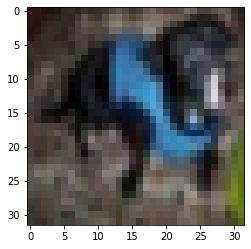

In [3]:
# let's look at our first image
plot_one_image(data, labels, 0)

label: road


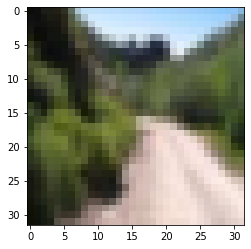

In [4]:
# let's look at an image of a road
plot_one_image(data, labels, 700)

How many dogs and roads do we have? 

In [5]:
label_counter = Counter(labels)
print(label_counter)
NUM_DOGS = label_counter['dog']
NUM_ROADS = label_counter['road']
print('Number of dogs: ', NUM_DOGS)
print('Number of roads: ', NUM_ROADS)

Counter({'dog': 600, 'road': 600})
Number of dogs:  600
Number of roads:  600


The dataset is organized such that the first 600 images are pictures of dogs and the last 600 images are pictures of roads.

### Task 1


**Look at a few more images of both classes.**



label: dog


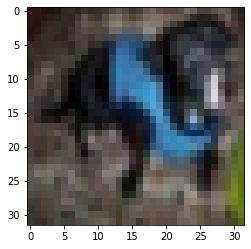

label: dog


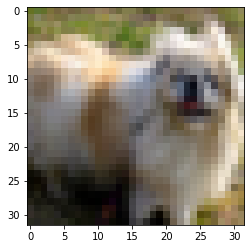

label: dog


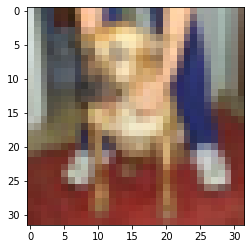

label: dog


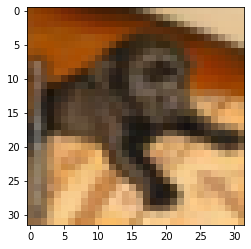

label: dog


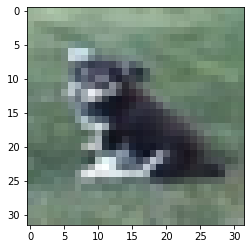

In [6]:
### YOUR CODE HERE
for i in range(0, 5):
  plot_one_image(data, labels, i)

### END CODE

Here, our images are stored as the color of each pixel in the image. 


In [7]:
print('One image looks like: ')
print(data[0])

One image looks like: 
[45 20 19 ... 83 99 31]


**What do you think these numbers mean?**

Each of these numbers is a single **input**. 

In [8]:
print('Each image is 32 x 32 pixels where each pixel has 3 values for \nred green and blue')
print('Each image has 32 x 32 x 3 = %d inputs'%data[0].shape)

Each image is 32 x 32 pixels where each pixel has 3 values for 
red green and blue
Each image has 32 x 32 x 3 = 3072 inputs


We use these **inputs** to classify, or predict, what our image is. 

Our image's category is contained in `labels`. Labels is a list of all of our images' categories. Each label is either `dog` or `road`. 

In [9]:
print('Our labels list looks like:')
print(set(labels))

Our labels list looks like:
{'road', 'dog'}


## A simple machine learner




We want to create a machine learning *model* that can tell us whether a new image is either a `dog` or a `road`. 

We will give our *model* a *training manual* of data and labels that it will study or train on. 

We then check how well our model is doing on a *test*, where it is given data and told to predict their labels. 

Finally, we check  how our model did by giving it a *test*. The accuracy score tells us what percentage of test data it classified correctly. 100% means that all the images were classifered correctly.



### Task 2 


Build our own KNN model where we change the number of neighbors.

In [10]:
### YOUR CODE HERE
# Preparing data and create training and test inputs and labels
inputs_train, inputs_test, labels_train, labels_test = model_selection.train_test_split(data, labels, test_size=0.2)

# Defining our classifier
knn = KNeighborsClassifier(n_neighbors=3)

# Training our model with its trianing input data and labels
knn.fit(inputs_train, labels_train)

# Predict what the classes are based on the testing data
predictions = knn.predict(inputs_test)

# Print the score on the testing data
print("KNN Testing Set Accuracy:")
print(accuracy_score(labels_test, predictions)*100)


### END CODE

KNN Testing Set Accuracy:
79.58333333333333


We can use our trained model to predict whether our car is seeing a `dog` or `road`. Let's try this out!

label: dog


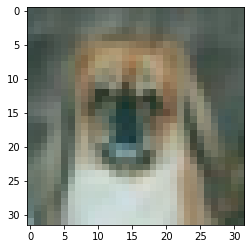

prediction: road


In [11]:
# Specify which image you want to show
image_id = 100

# Visualize the image
plot_one_image(inputs_test, labels_test, image_id)

# Use the model to predict what this might be and print it
print('prediction:', knn.predict([inputs_test[image_id]])[0])

### Task 3

We do alright on the classification, but our classifier could do much better. Let's put on our detective hats to determine what the root cause of the incorrect classifications are.

**Print out 4 images of true positives, 4 images of true negatives, 4 images of false positives, and 4 images of false negatives. What are the reasons for failure (both for false positives and false negatives)? **

True positive:
label: dog


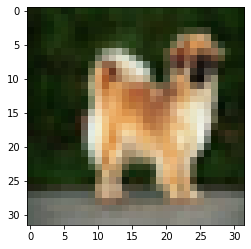

True negative:
label: road


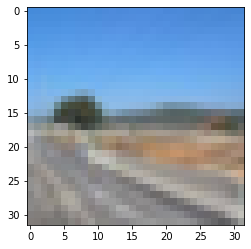

True positive:
label: dog


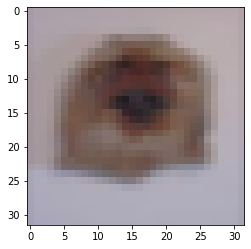

True negative:
label: road


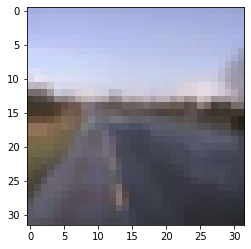

True negative:
label: road


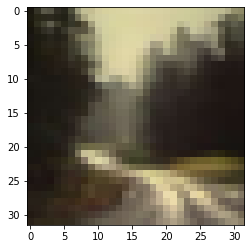

True negative:
label: road


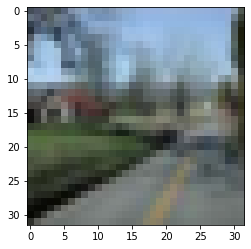

True negative:
label: road


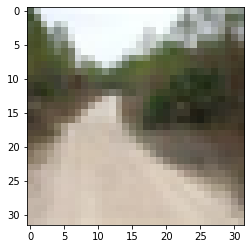

True positive:
label: dog


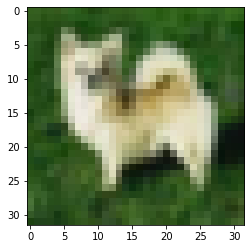

True negative:
label: road


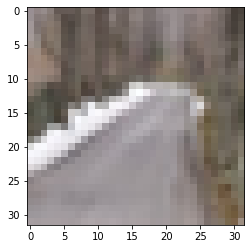

True negative:
label: road


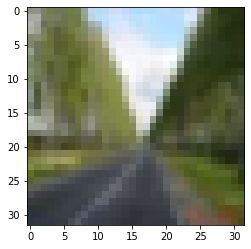

True negative:
label: road


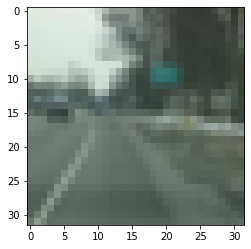

True negative:
label: road


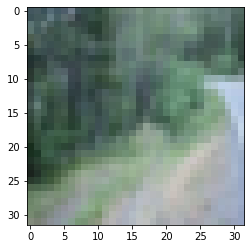

True positive:
label: dog


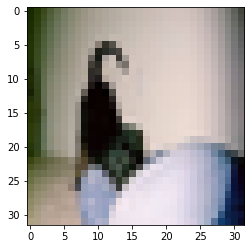

True positive:
label: dog


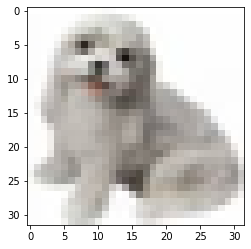

True negative:
label: road


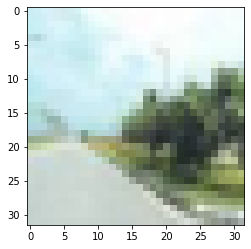

True negative:
label: road


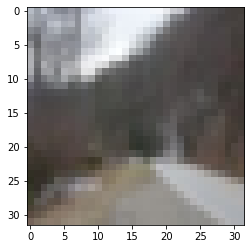

True negative:
label: road


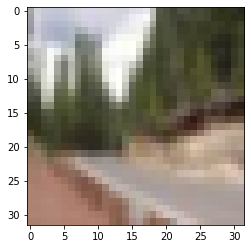

False negative:
label: dog


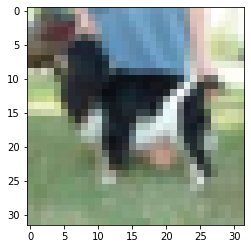

True negative:
label: road


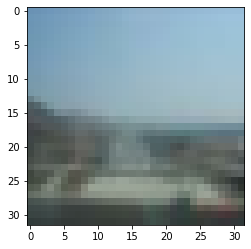

True negative:
label: road


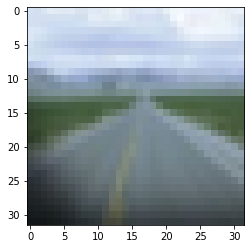

True positive:
label: dog


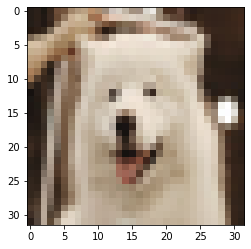

True negative:
label: road


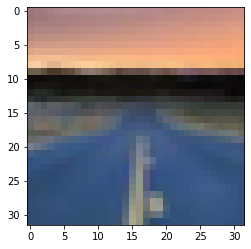

True negative:
label: road


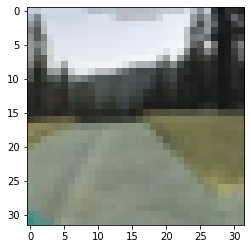

True negative:
label: road


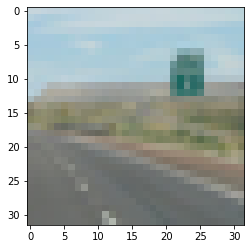

True negative:
label: road


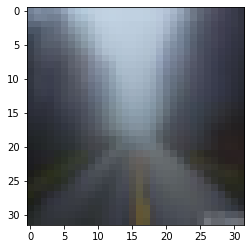

True positive:
label: dog


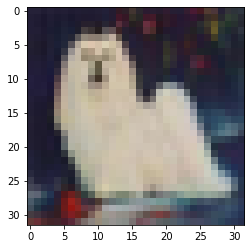

True positive:
label: dog


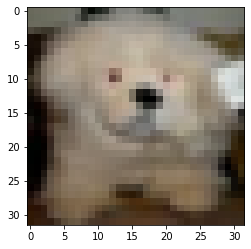

True negative:
label: road


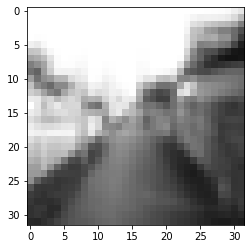

True positive:
label: dog


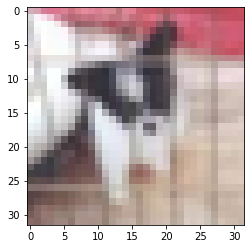

True negative:
label: road


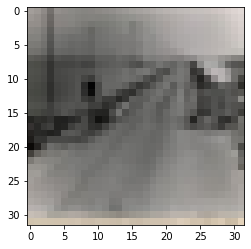

True negative:
label: road


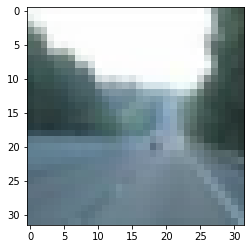

True negative:
label: road


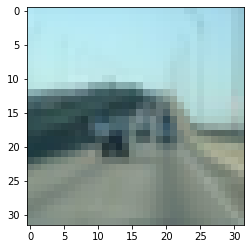

False negative:
label: dog


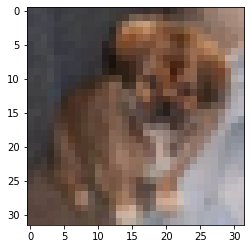

True negative:
label: road


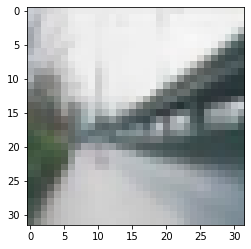

True negative:
label: road


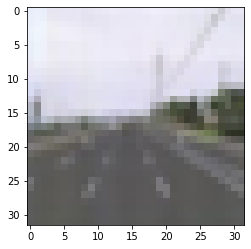

False negative:
label: dog


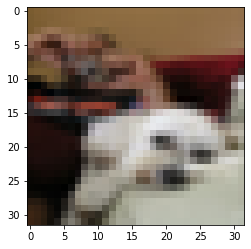

False negative:
label: dog


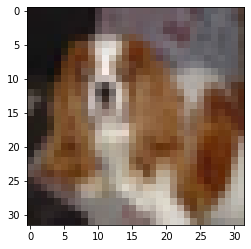

True negative:
label: road


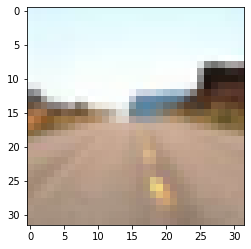

True positive:
label: dog


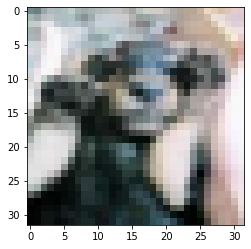

True negative:
label: road


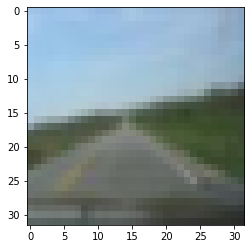

True positive:
label: dog


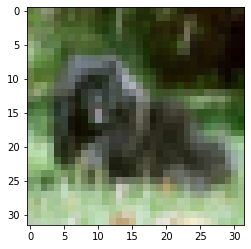

True positive:
label: dog


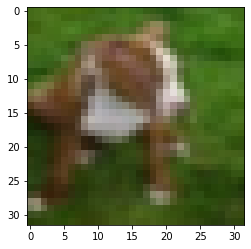

True negative:
label: road


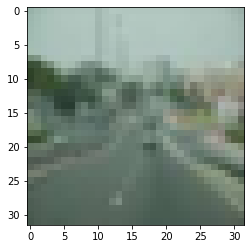

False negative:
label: dog


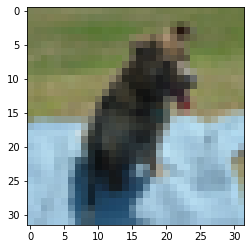

True positive:
label: dog


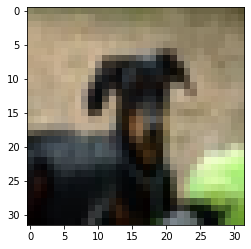

True negative:
label: road


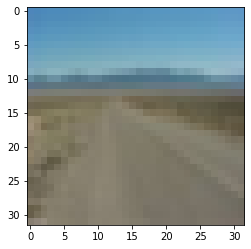

True positive:
label: dog


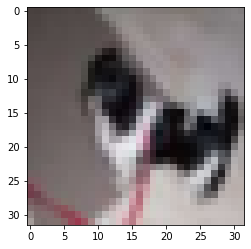

False negative:
label: dog


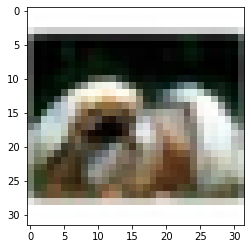

False negative:
label: dog


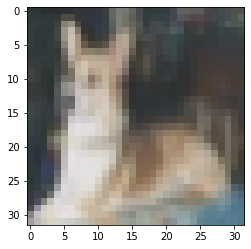

True negative:
label: road


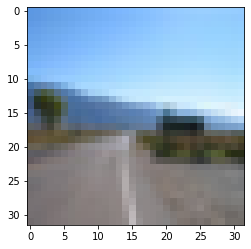

True negative:
label: road


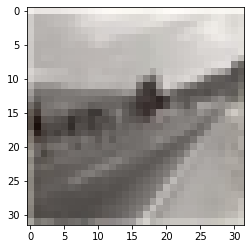

True negative:
label: road


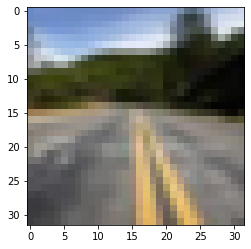

True positive:
label: dog


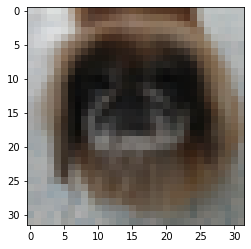

True negative:
label: road


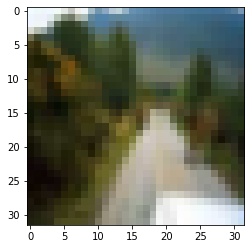

True negative:
label: road


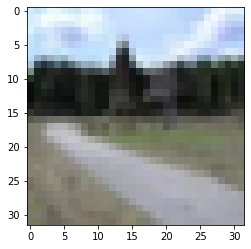

True negative:
label: road


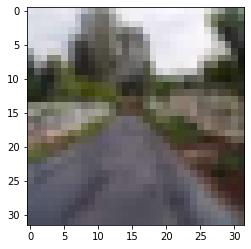

True negative:
label: road


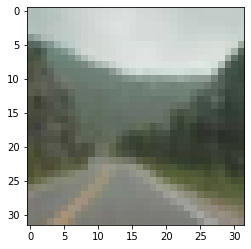

False negative:
label: dog


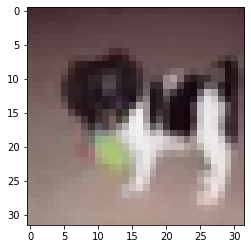

False negative:
label: dog


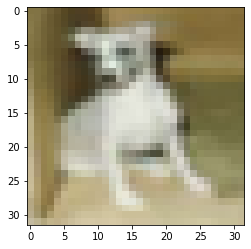

True positive:
label: dog


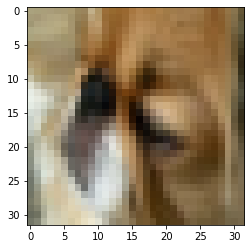

True positive:
label: dog


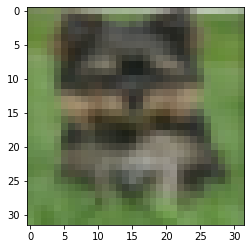

True negative:
label: road


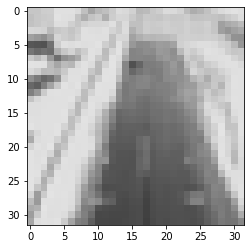

True positive:
label: dog


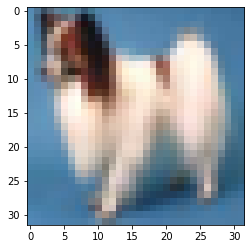

True negative:
label: road


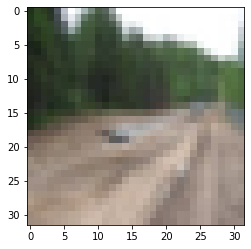

True positive:
label: dog


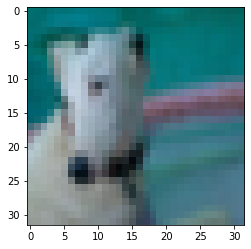

True positive:
label: dog


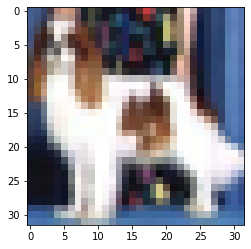

True negative:
label: road


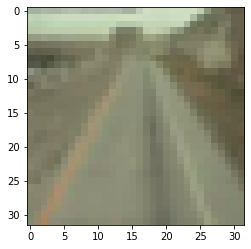

True negative:
label: road


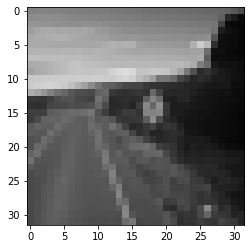

False negative:
label: dog


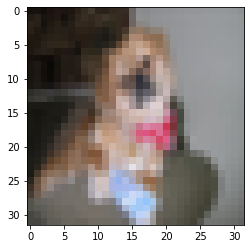

True negative:
label: road


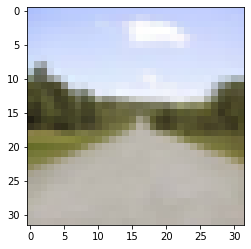

True positive:
label: dog


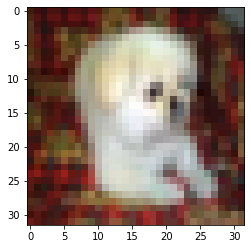

False negative:
label: dog


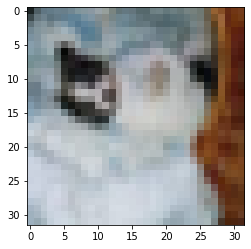

True positive:
label: dog


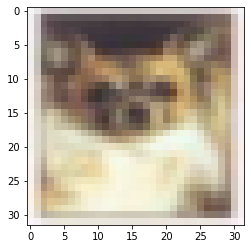

False negative:
label: dog


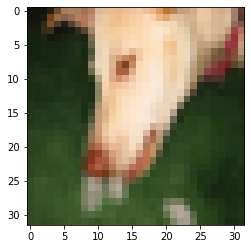

True positive:
label: dog


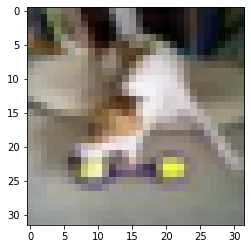

True negative:
label: road


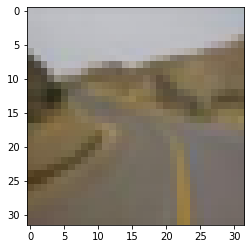

True negative:
label: road


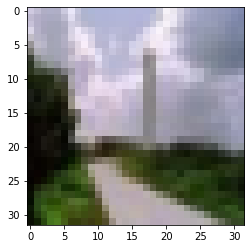

True negative:
label: road


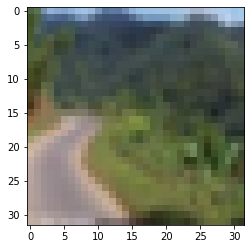

False negative:
label: dog


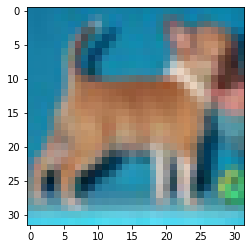

True negative:
label: road


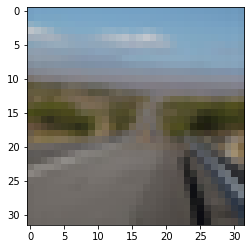

True negative:
label: road


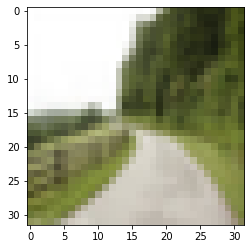

True negative:
label: road


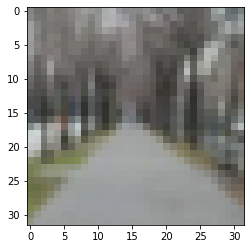

False negative:
label: dog


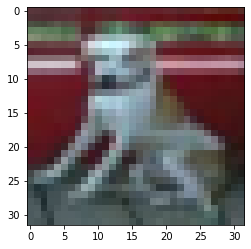

True negative:
label: road


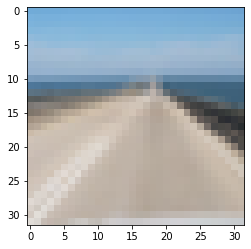

True negative:
label: road


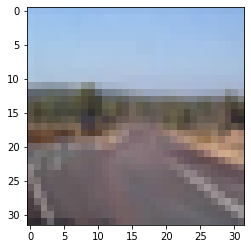

True negative:
label: road


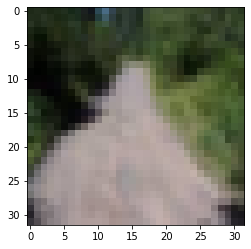

True positive:
label: dog


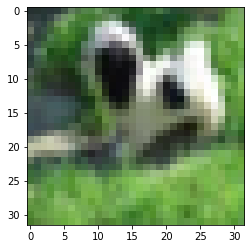

True positive:
label: dog


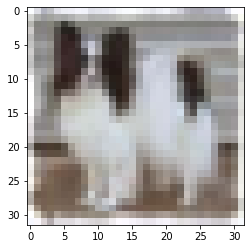

False negative:
label: dog


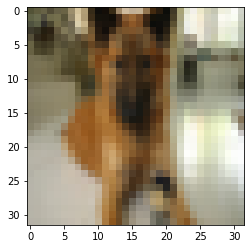

True positive:
label: dog


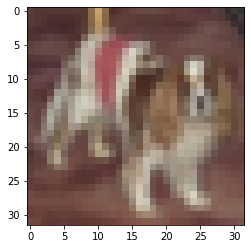

True positive:
label: dog


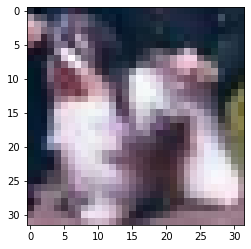

True negative:
label: road


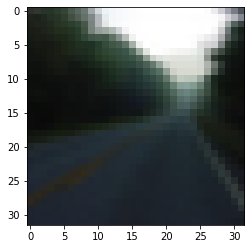

True negative:
label: road


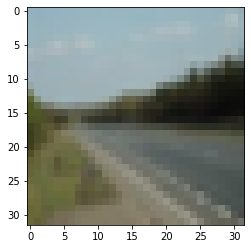

True negative:
label: road


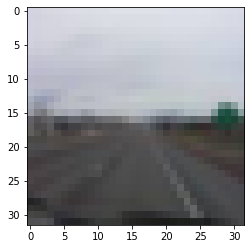

True negative:
label: road


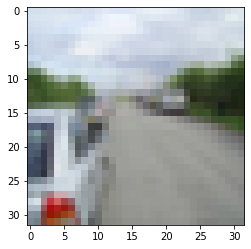

True positive:
label: dog


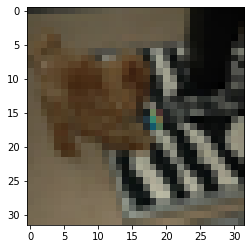

True positive:
label: dog


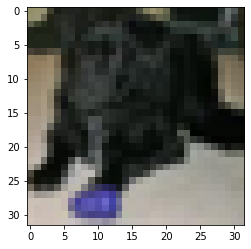

True negative:
label: road


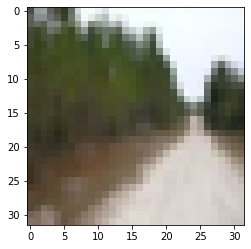

True negative:
label: road


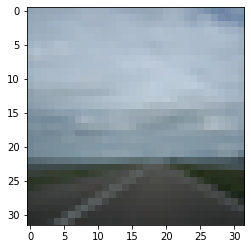

True negative:
label: road


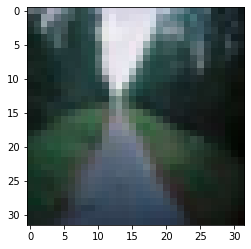

False negative:
label: dog


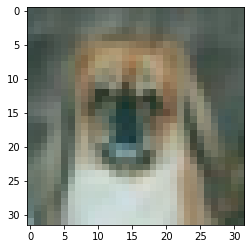

True positive:
label: dog


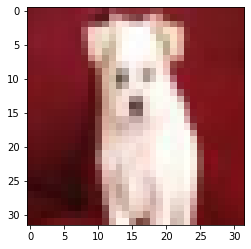

False negative:
label: dog


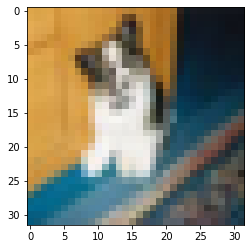

True positive:
label: dog


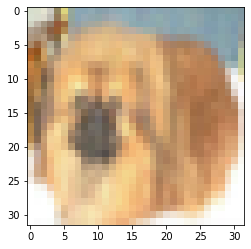

True positive:
label: dog


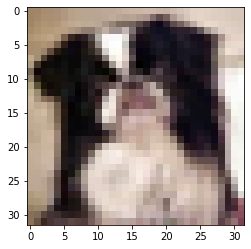

True negative:
label: road


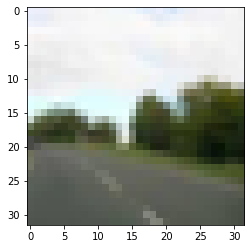

True negative:
label: road


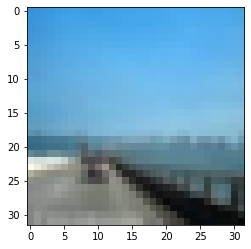

True positive:
label: dog


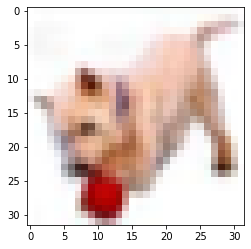

True negative:
label: road


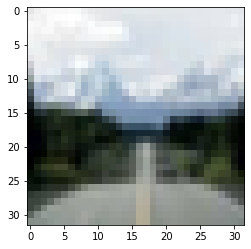

True positive:
label: dog


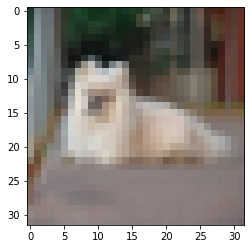

True negative:
label: road


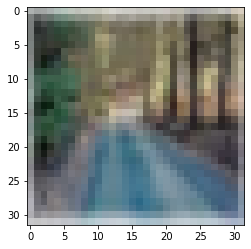

False negative:
label: dog


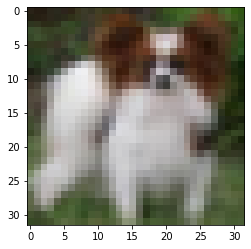

True positive:
label: dog


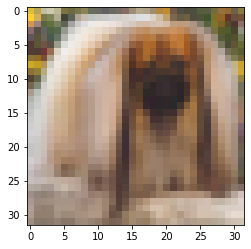

True negative:
label: road


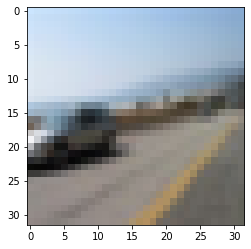

True negative:
label: road


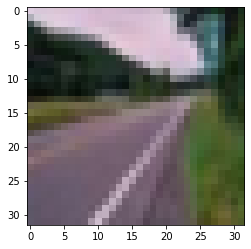

True negative:
label: road


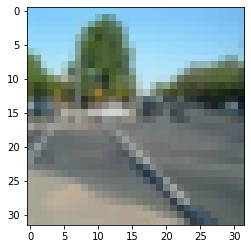

True negative:
label: road


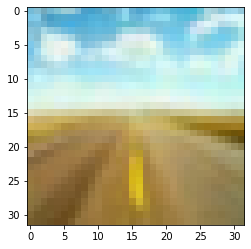

False negative:
label: dog


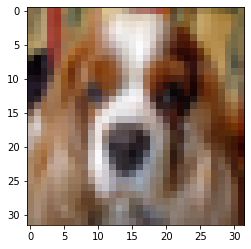

True negative:
label: road


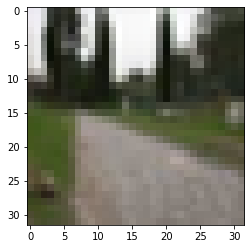

False negative:
label: dog


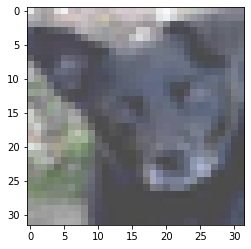

True positive:
label: dog


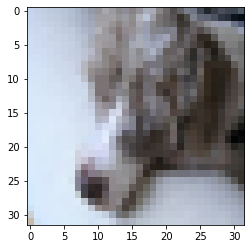

True positive:
label: dog


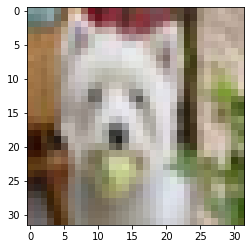

True positive:
label: dog


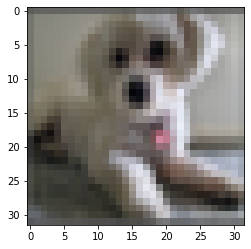

True negative:
label: road


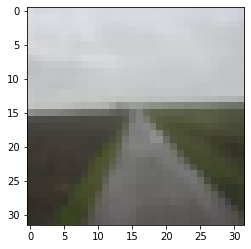

True positive:
label: dog


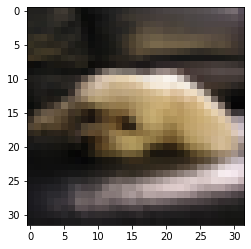

True positive:
label: dog


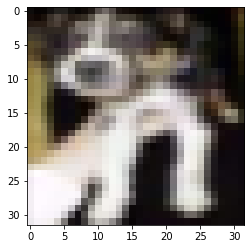

False negative:
label: dog


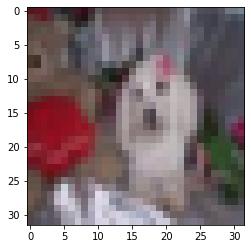

True positive:
label: dog


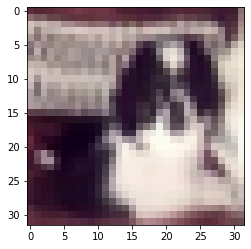

False negative:
label: dog


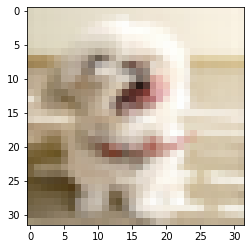

True negative:
label: road


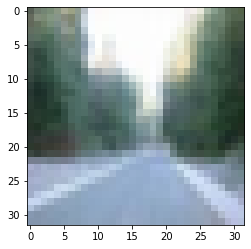

True negative:
label: road


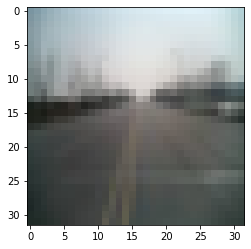

True negative:
label: road


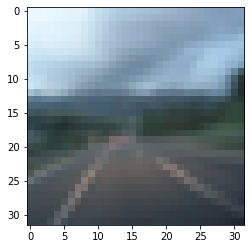

False negative:
label: dog


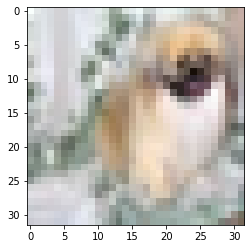

True positive:
label: dog


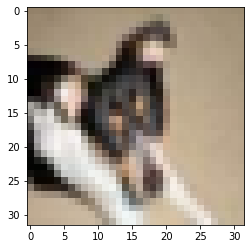

True negative:
label: road


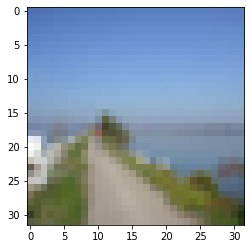

True positive:
label: dog


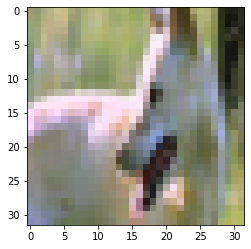

True negative:
label: road


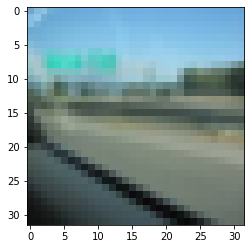

True negative:
label: road


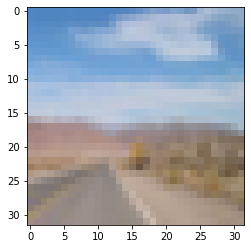

False negative:
label: dog


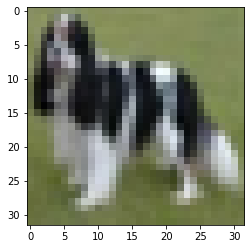

False negative:
label: dog


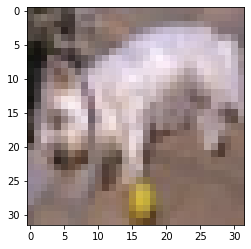

True negative:
label: road


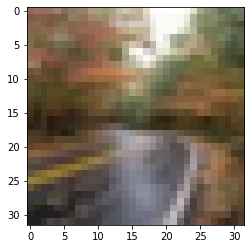

True positive:
label: dog


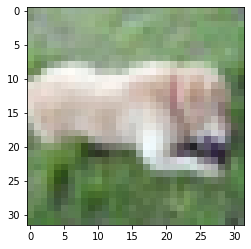

True negative:
label: road


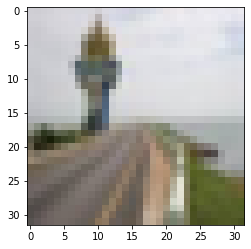

True positive:
label: dog


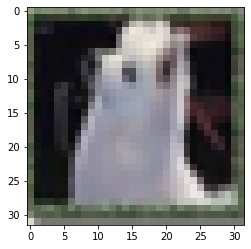

True negative:
label: road


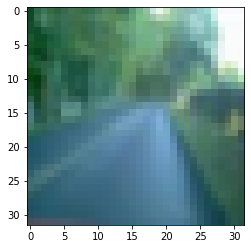

True positive:
label: dog


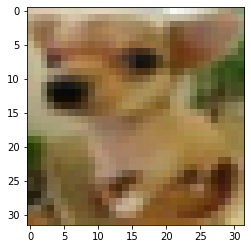

False negative:
label: dog


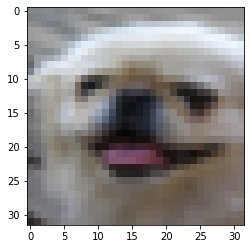

True negative:
label: road


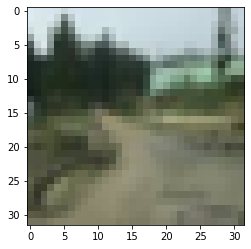

True positive:
label: dog


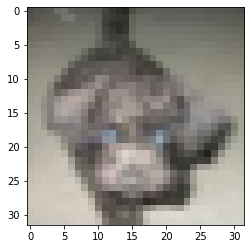

True negative:
label: road


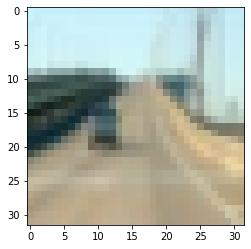

True negative:
label: road


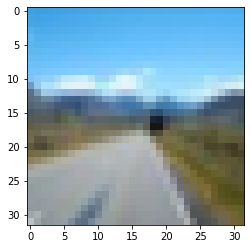

True negative:
label: road


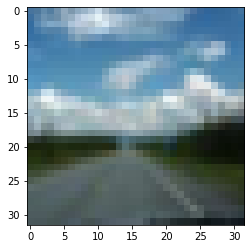

True negative:
label: road


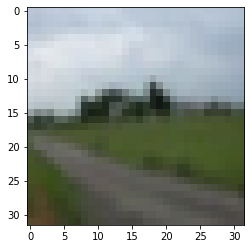

True negative:
label: road


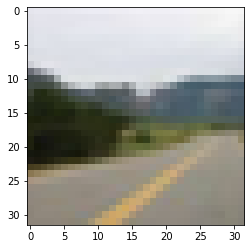

True negative:
label: road


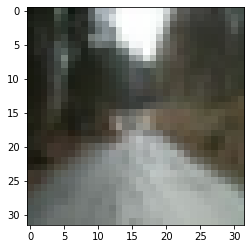

False negative:
label: dog


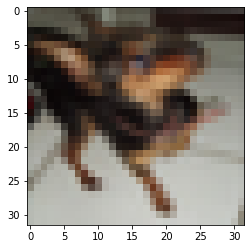

True negative:
label: road


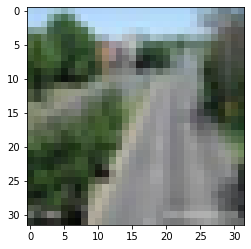

True negative:
label: road


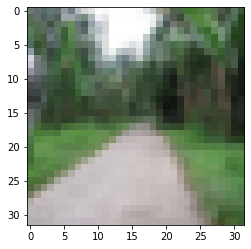

False negative:
label: dog


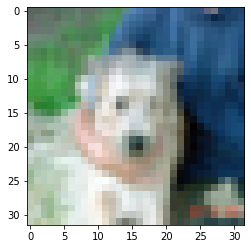

False negative:
label: dog


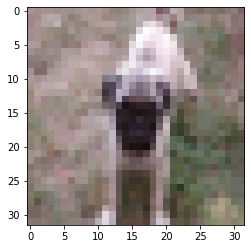

True positive:
label: dog


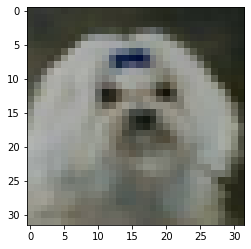

True negative:
label: road


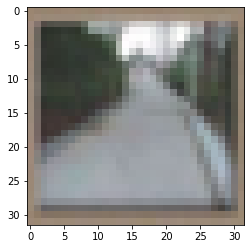

True positive:
label: dog


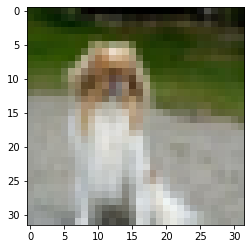

True negative:
label: road


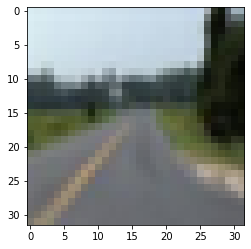

False negative:
label: dog


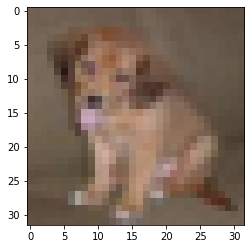

False negative:
label: dog


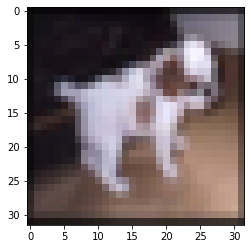

False negative:
label: dog


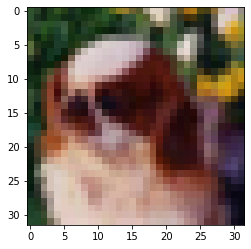

True negative:
label: road


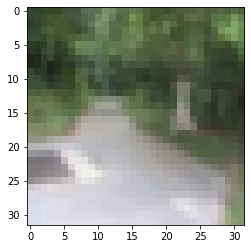

True positive:
label: dog


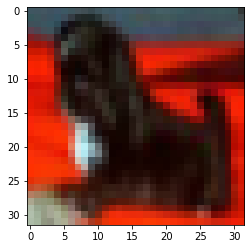

True negative:
label: road


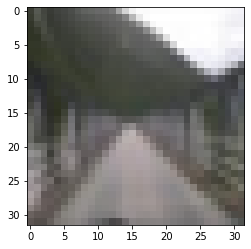

False negative:
label: dog


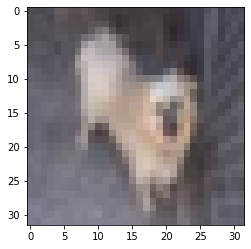

True negative:
label: road


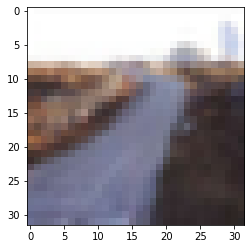

False negative:
label: dog


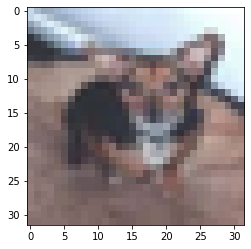

True negative:
label: road


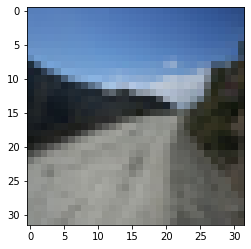

True positive:
label: dog


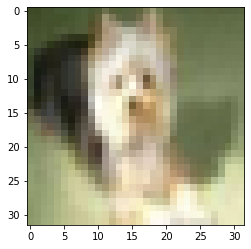

True negative:
label: road


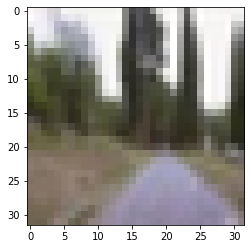

True positive:
label: dog


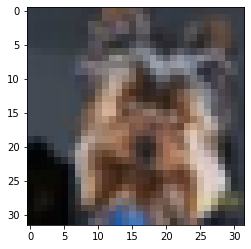

True positive:
label: dog


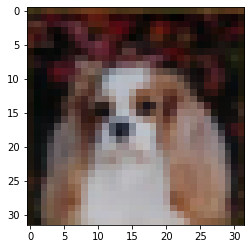

True positive:
label: dog


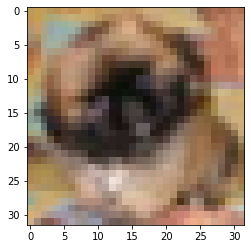

True positive:
label: dog


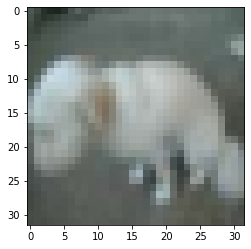

True positive:
label: dog


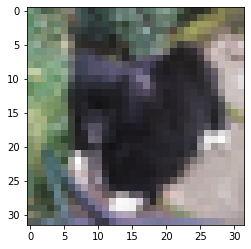

False negative:
label: dog


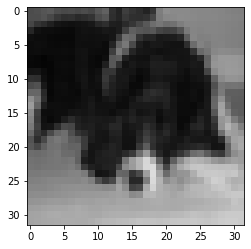

True negative:
label: road


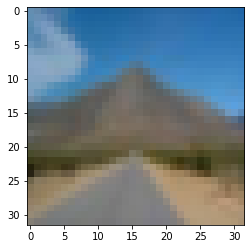

True negative:
label: road


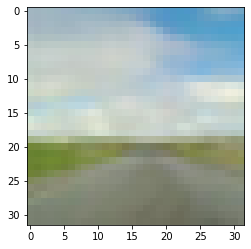

True negative:
label: road


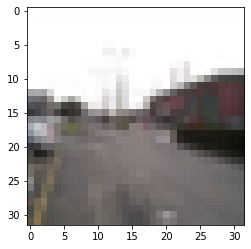

True positive:
label: dog


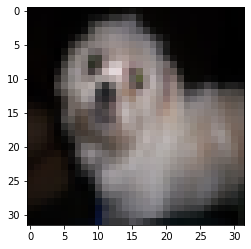

True negative:
label: road


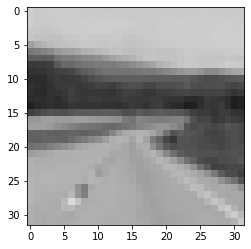

True negative:
label: road


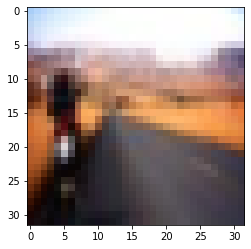

True negative:
label: road


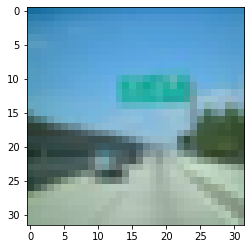

True negative:
label: road


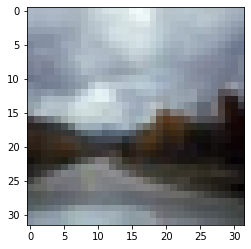

True positive:
label: dog


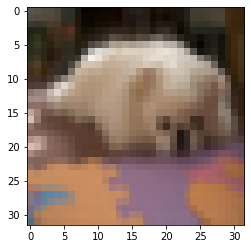

False negative:
label: dog


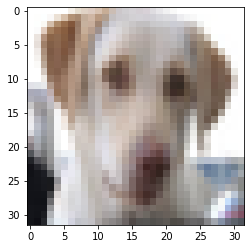

True positive:
label: dog


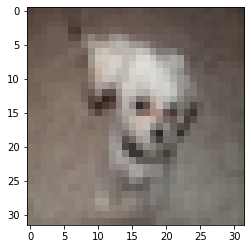

False negative:
label: dog


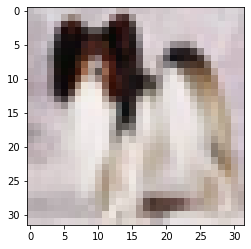

True positive:
label: dog


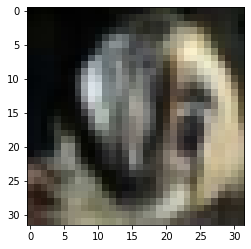

True positive:
label: dog


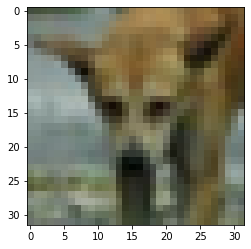

True positive:
label: dog


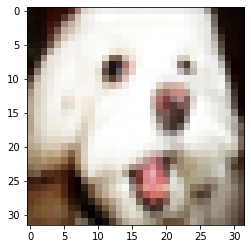

True positive:
label: dog


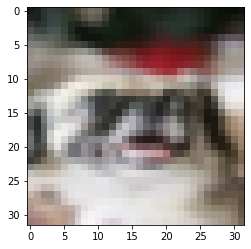

False negative:
label: dog


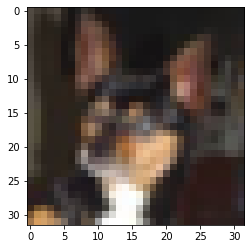

True negative:
label: road


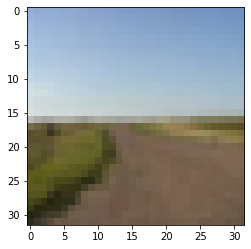

True negative:
label: road


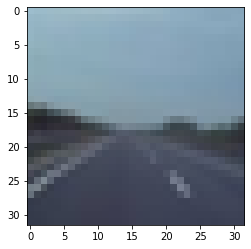

True positive:
label: dog


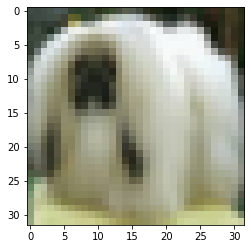

True negative:
label: road


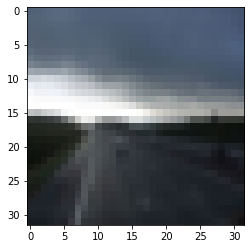

True negative:
label: road


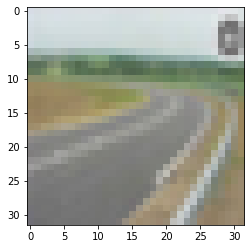

True negative:
label: road


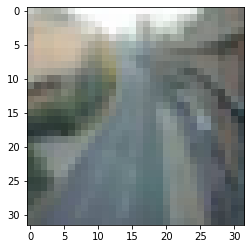

False negative:
label: dog


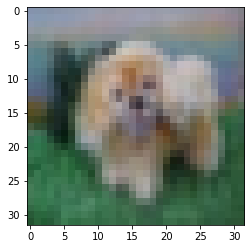

True negative:
label: road


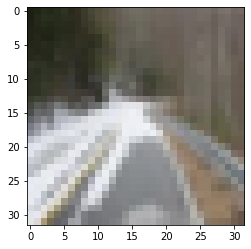

True positive:
label: dog


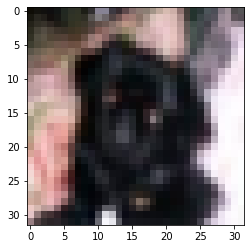

True negative:
label: road


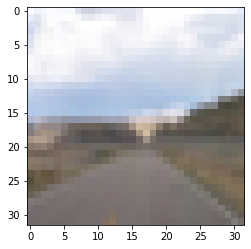

True negative:
label: road


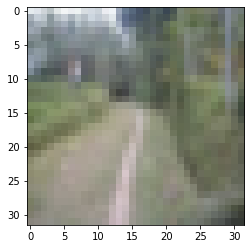

True positive:
label: dog


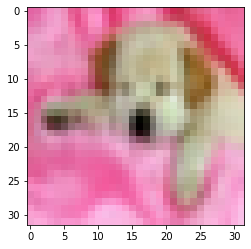

False negative:
label: dog


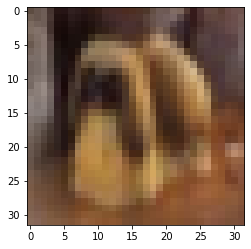

True positive:
label: dog


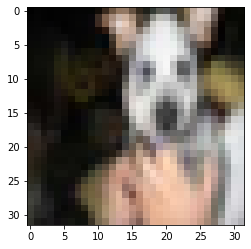

True negative:
label: road


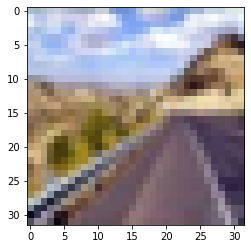

False negative:
label: dog


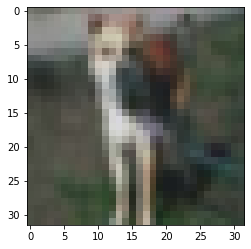

False negative:
label: dog


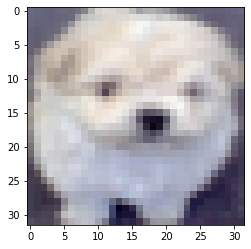

True positive:
label: dog


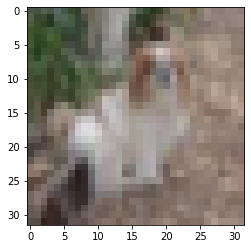

True positive:
label: dog


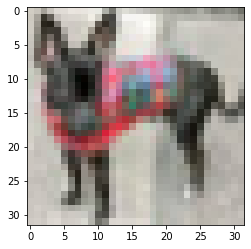

True negative:
label: road


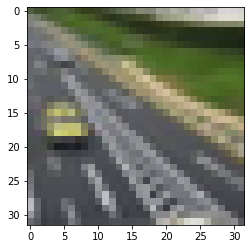

True positive:
label: dog


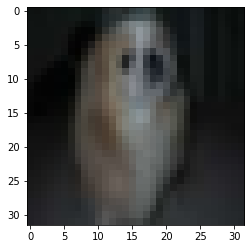

True positive:
label: dog


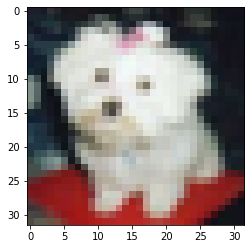

True negative:
label: road


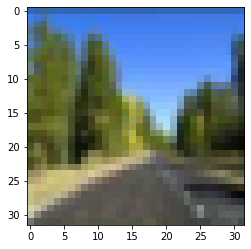

False negative:
label: dog


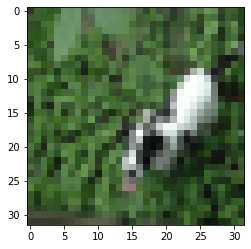

True negative:
label: road


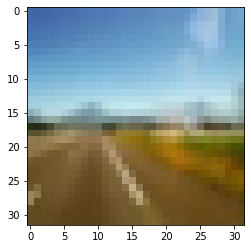

False negative:
label: dog


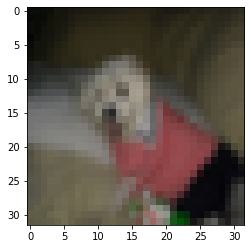

True positive:
label: dog


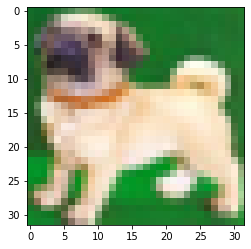

False negative:
label: dog


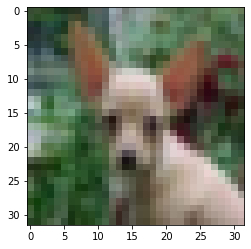

False negative:
label: dog


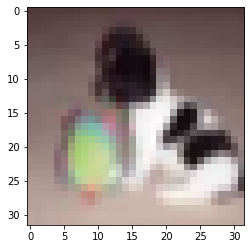

True negative:
label: road


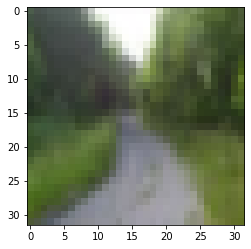

False negative:
label: dog


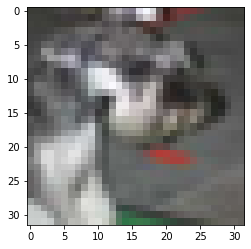

True negative:
label: road


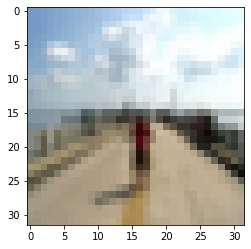

True positive:
label: dog


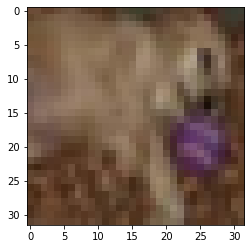

True negative:
label: road


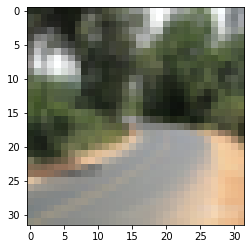

True negative:
label: road


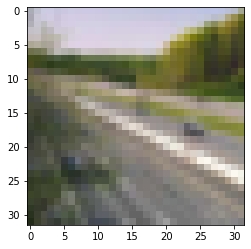

True positive:
label: dog


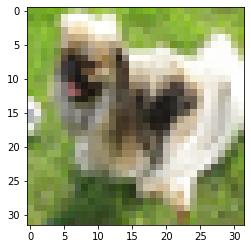

True negative:
label: road


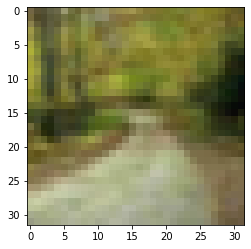

True positive:
label: dog


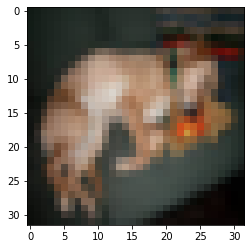

False negative:
label: dog


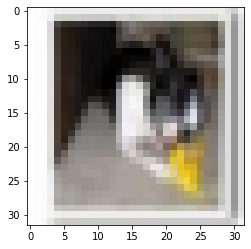

False negative:
label: dog


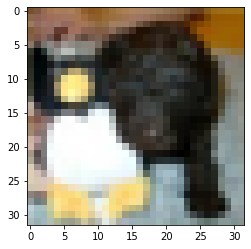

True negative:
label: road


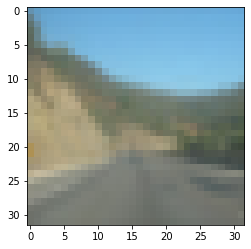

In [12]:
true_positives = 0
false_positives = 0
true_negatives = 0
false_negatives = 0

for i in range(len(labels_test)):
  prediction = knn.predict([inputs_test[i]])[0] 

  # True positive.
  if prediction == labels_test[i] and prediction == 'dog':
    print('True positive:')
    plot_one_image(inputs_test, labels_test, i)
    true_positives += 1
    
  # True negative.
  elif prediction == labels_test[i] and prediction == 'road':
    print('True negative:')
    plot_one_image(inputs_test, labels_test, i)
    true_negatives += 1
  
  # False positive.
  elif prediction != labels_test[i] and prediction == 'dog':
    print('False positive:')
    plot_one_image(inputs_test, labels_test, i)
    false_positives += 1
  
  # False negative.
  elif prediction != labels_test[i] and prediction == 'road':
    print('False negative:')
    plot_one_image(inputs_test, labels_test, i)
    false_negatives += 1
  
  # Stop when we have at least 4 TP, TN, FP, and FN.
  if true_positives >= 1 and false_positives >= 1 and \
    true_negatives >= 1 and false_negatives >= 1:
    break

**What are the causes of false positives and false negatives?**

### Task 4


Determine the optimal value of "K" for our data. Use a for-loop to loop through different values of "K". In particular, *at the very least* try K = 1, 3, 5, 10, 20, and 30. For each of these values of "K", define a new KNN model, train it, and evaluate the accuracy.

In [13]:
### YOUR CODE HERE
for i in [1, 3, 5, 10, 20, 30]:
  # Defining our classifier
  knn = KNeighborsClassifier(n_neighbors=i)

  # Training our model with its trianing input data and labels
  knn.fit(inputs_train, labels_train)
  
  # predictions for test
  predictions = knn.predict(inputs_test)

  # Print the score on the testing data
  print("KNN Testing Set Accuracy for %d neighbors:"%i)
  print(accuracy_score(labels_test, predictions)*100)
### END CODE

KNN Testing Set Accuracy for 1 neighbors:
81.25
KNN Testing Set Accuracy for 3 neighbors:
79.58333333333333
KNN Testing Set Accuracy for 5 neighbors:
78.75
KNN Testing Set Accuracy for 10 neighbors:
84.16666666666667
KNN Testing Set Accuracy for 20 neighbors:
83.75
KNN Testing Set Accuracy for 30 neighbors:
81.25


**What is the optimal value of "K"?**

## TENSORFLOW PLAYGROUND ACTIVITY (20 MINS) 

Open [this](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.62283&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&learningRate_hide=true&batchSize_hide=true&stepButton_hide=true&activation_hide=true) to understand Neural Networks!

## Using a simple neural network

Let's now try a neural network for this and see how well it does. 

To build a simple neural network, we use `MLPClassifier` from scikit-learn. We will play with the **number of neurons** and the **number of hidden layers** to adjust the complexity of our model! Just like we did in Playground. 

Let's see how well we can do. :) 

**Example 1:**

If we want to create a neural network with 1 hidden layer and 3 neurons, we would say:

`nnet = MLPClassifier(hidden_layer_sizes=(3)) `

**Example 2:**

If we want to create a neural network with 2 hidden layers and 3 neurons in each layer:

`nnet = MLPClassifier(hidden_layer_sizes=(3, 3)) `

In [14]:
# Create and train our multi layer perceptron model
nnet = MLPClassifier(hidden_layer_sizes=(3), max_iter= 10000000)  ## How many hidden layers? How many neurons does this have?
nnet.fit(inputs_train, labels_train)

# Predict what the classes are based on the testing data
predictions = nnet.predict(inputs_test)

# Print the score on the testing data
print("MLP Testing Set Score:")
print(accuracy_score(labels_test, predictions)*100)

MLP Testing Set Score:
51.66666666666667


**How well did your neural network perform?** 

Multilayer perceptrons are more complex models and it can be difficult to find the right "settings" for them. It takes some trial and error!

**Try the following out and see how well you can get your network to do:**
* Change the number of hidden neurons and hidden layers to see how well you can do.
* Increase or decrease the number of iterations

### Task 5

Similar to what you did for KNNs, use a for loop to automate your investigation. This time, however, you will explore different numbers of hidden layers, the size of the hidden layers, and the number of iterations.

In [15]:
### YOUR CODE HERE
for ilayer in [(1,1), (3,3), (5,5), (8,6), (10,10,10), (10,10,5)]:

  print('Layer params are ...')
  print(ilayer)
  nnet = MLPClassifier(hidden_layer_sizes=ilayer, max_iter= 100)  ## How many hidden layers? How many neurons does this have?  
  
  nnet.fit(inputs_train, labels_train)

  # Predict what the classes are based on the testing data
  predictions = nnet.predict(inputs_test)

  # Print the score on the testing data
  print("MLP Testing Set Score:")
  print(accuracy_score(labels_test, predictions)*100)  
### END CODE

Layer params are ...
(1, 1)


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP Testing Set Score:
48.333333333333336
Layer params are ...
(3, 3)
MLP Testing Set Score:
51.66666666666667
Layer params are ...
(5, 5)
MLP Testing Set Score:
48.333333333333336
Layer params are ...
(8, 6)


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP Testing Set Score:
48.333333333333336
Layer params are ...
(10, 10, 10)
MLP Testing Set Score:
87.5
Layer params are ...
(10, 10, 5)
MLP Testing Set Score:
51.66666666666667


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Models for vision: Convolutional Neural Networks

There is a famous type of neural network known as convolutional neural networks (CNNs). These types of neural networks work particularly well on problems to do with computer vision. Let's try one out!

To load up a simple CNN on scikit-learn, just run:

`cnn = CNNClassifier(num_epochs=N)`

The num_epochs represents how many times the neural network passes through the training dataset. 

### Task 6

In [16]:
### YOUR CODE HERE
cnn = CNNClassifier(num_epochs=30)

cnn.fit(inputs_train, labels_train)

# Predict what the classes are based on the testing data
predictions = cnn.predict(inputs_test)

# Print the score on the testing data
print("CNN Testing Set Score:")
print(accuracy_score(labels_test, predictions)*100)
### END CODE

Epoch 1/30
 - 8s - loss: 1.0140 - accuracy: 0.6865
Epoch 2/30
 - 1s - loss: 0.3474 - accuracy: 0.8583
Epoch 3/30
 - 1s - loss: 0.2819 - accuracy: 0.8906
Epoch 4/30
 - 1s - loss: 0.2346 - accuracy: 0.9062
Epoch 5/30
 - 1s - loss: 0.2121 - accuracy: 0.9187
Epoch 6/30
 - 1s - loss: 0.1948 - accuracy: 0.9333
Epoch 7/30
 - 1s - loss: 0.1562 - accuracy: 0.9406
Epoch 8/30
 - 1s - loss: 0.1577 - accuracy: 0.9479
Epoch 9/30
 - 1s - loss: 0.1507 - accuracy: 0.9385
Epoch 10/30
 - 1s - loss: 0.1334 - accuracy: 0.9531
Epoch 11/30
 - 1s - loss: 0.1280 - accuracy: 0.9594
Epoch 12/30
 - 1s - loss: 0.1172 - accuracy: 0.9615
Epoch 13/30
 - 1s - loss: 0.1157 - accuracy: 0.9635
Epoch 14/30
 - 1s - loss: 0.1083 - accuracy: 0.9635
Epoch 15/30
 - 1s - loss: 0.0929 - accuracy: 0.9708
Epoch 16/30
 - 1s - loss: 0.1110 - accuracy: 0.9604
Epoch 17/30
 - 1s - loss: 0.0803 - accuracy: 0.9729
Epoch 18/30
 - 1s - loss: 0.0794 - accuracy: 0.9750
Epoch 19/30
 - 1s - loss: 0.0826 - accuracy: 0.9729
Epoch 20/30
 - 1s - l

**How well did your neural network perform?** 

CNNs typically perform significantly better than MLPs on vision problems but, like MLPs, aren't always consistent when they are applied. They are also sensitive to a number of parameters. 

## Training and Validation Curves

An important aspect of training neural networks is to prevent overfitting. In brief, we know that our model is overfitting when our test set accuracy is lower than our training (or validation) set accuracy.

```
history = model.fit(inputs_train, labels_train, validation_data=(inputs_test, labels_test_numerical))
plot_acc(history)
```



### Task 7

Plot a train vs. validation curve for our CNN model. 

**After how many epochs does the model begin to overfit?** Overfitting occurs when the validation accuracy starts to drop below the training accuracy.

Train on 960 samples, validate on 240 samples
Epoch 1/80
 - 1s - loss: 0.8588 - accuracy: 0.7573 - val_loss: 0.2541 - val_accuracy: 0.9125
Epoch 2/80
 - 1s - loss: 0.3599 - accuracy: 0.8687 - val_loss: 0.2138 - val_accuracy: 0.9125
Epoch 3/80
 - 1s - loss: 0.2442 - accuracy: 0.9052 - val_loss: 0.2551 - val_accuracy: 0.9083
Epoch 4/80
 - 1s - loss: 0.2097 - accuracy: 0.9146 - val_loss: 0.1579 - val_accuracy: 0.9292
Epoch 5/80
 - 1s - loss: 0.1932 - accuracy: 0.9312 - val_loss: 0.1735 - val_accuracy: 0.9417
Epoch 6/80
 - 1s - loss: 0.1766 - accuracy: 0.9365 - val_loss: 0.1402 - val_accuracy: 0.9500
Epoch 7/80
 - 1s - loss: 0.1542 - accuracy: 0.9458 - val_loss: 0.1444 - val_accuracy: 0.9458
Epoch 8/80
 - 1s - loss: 0.1416 - accuracy: 0.9542 - val_loss: 0.1245 - val_accuracy: 0.9458
Epoch 9/80
 - 1s - loss: 0.1225 - accuracy: 0.9573 - val_loss: 0.3288 - val_accuracy: 0.9042
Epoch 10/80
 - 1s - loss: 0.1113 - accuracy: 0.9552 - val_loss: 0.1290 - val_accuracy: 0.9583
Epoch 11/80
 - 1s - los

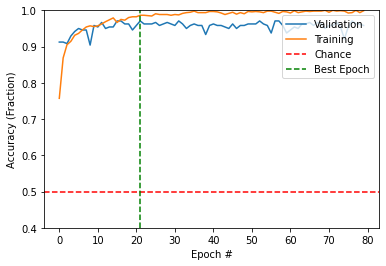

In [17]:
### YOUR CODE HERE
cnn = CNNClassifier(num_epochs=80)

labels_train_numerical = categorical_to_numpy(labels_train)
labels_test_numerical = categorical_to_numpy(labels_test)

history = cnn.fit(inputs_train, labels_train_numerical, \
                  validation_data=(inputs_test, labels_test_numerical))
plot_acc(history)
### END CODE